In [1]:
import pandas as pd
import pickle as pkl
import numpy as np

import matplotlib.pyplot as plt

import scanpy as sc
%matplotlib inline
import matplotlib

### Random baseline

In [2]:
def generate_random_rounds(all_genes, round0=None, rounds = 16, sample_size=64):
    past_set =list(all_genes)
    random_rounds = {}
    if round0 is not None:
        random_rounds[0] = round0
    else:
        random_rounds[0] = np.random.choice(all_genes, sample_size)
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_size)])
        past_set = list(selection_set)
        
    return random_rounds

def generate_random_rounds_custom(all_genes, rounds = 16, sample_sizes=None):
    past_set =list(all_genes)
    random_rounds = {}
    random_rounds[0] = []
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_sizes[i])])
        past_set = list(selection_set)
        
    return random_rounds

def return_hits(list_):
    return list(set(list_).intersection(set(topmovers)))

def get_all_sampled_genes(exp_path):
    all_sampled_genes = []
    num_rounds = len(glob.glob(exp_path + '*'))
    for i in range(num_rounds):
        exp_path_ = exp_path + str(i) + '.npy'
        all_sampled_genes.append(np.load(exp_path_))
    return all_sampled_genes

def get_successful_sample_sizes(sampled_genes):
    sizes = []
    prev_size = 0
    for sample in sampled_genes:
        sizes.append(len(sample)-prev_size)
        prev_size = prev_size + sizes[-1]
    return sizes

def return_hits(arr):
    return list(set(arr).intersection(set(topmovers)))

In [8]:
REPS = ['1', '2']
ACQUISITION_FUNCTIONS = ["random", "softuncertain", "topuncertain",
                         "marginsample", "coreset", "badge",
                         "kmeans_embedding", "kmeans_data"]
        #"adversarialBIM", "custom"
#ACQUISITION_FUNCTIONS = ["topuncertain"]
SCREEN_NAMES = ['IL2']

num_reps = len(REPS)
sample_size=32
num_steps = 30

screen_name = SCREEN_NAMES[0]
data_name = screen_name.lower()

data_df = pd.read_csv('/dfs/user/yhr/research_assistant_orig/datasets/ground_truth_'+screen_name+'.csv')
topmovers = np.load('/dfs/user/yhr/research_assistant_orig/datasets/topmovers_'+screen_name+'.npy')
all_genes = data_df['Gene'].values

### Read in model explanations

In [249]:
import glob
import os
import glob

without_fail_filter = glob.glob('/dfs/user/yhr/AI_RA/research_assistant/logs/agent_log/IL2/IL2_exp?')
without_fail_filter += glob.glob('/dfs/user/yhr/AI_RA/research_assistant/logs/agent_log/IL2/IL2_exp??')
with_fail_filter = glob.glob('/dfs/user/yhr/AI_RA/research_assistant/logs/agent_log/IL2/IL2_exp_nofail_??')

all_files = glob.glob('/dfs/user/yhr/AI_RA/research_assistant/logs/agent_log/IL2/IL2_exp*')

agent_paths = without_fail_filter + with_fail_filter
##agent_paths = all_files
exp_paths = {i: os.path.join(path,'sampled_genes_') for i, path in enumerate(agent_paths)}

In [250]:
sampled_genes = {}
sample_sizes = {}
hits = {}
hit_rates_plan = {}
num_rounds = 24
num_steps = 25
num_reps = len(exp_paths)
filter_zero_sets = True
min_rounds = 15

for rep in exp_paths:
    sampled_genes[rep] = get_all_sampled_genes(exp_paths[rep])
    sample_sizes[rep] = get_successful_sample_sizes(sampled_genes[rep])
    if np.sum(np.array(sample_sizes[rep]) > 0) < min_rounds:
        sampled_genes.pop(rep, None)
        continue
    
    if filter_zero_sets:
         sampled_genes[rep] = [sampled_genes[rep][itr] for itr in np.where(np.array(sample_sizes[rep])!= 0)[0]]

    hits[rep] = []
    hit_rates_plan[rep] = []
    hits[rep] = [return_hits(x) for x in sampled_genes[rep]]
    hit_rates_plan[rep] = [len(x)/len(topmovers) for x in hits[rep]]
    
num_steps_claude_plan = np.min([len(x) for x in hit_rates_plan.values()])

In [251]:
def get_ai_ra_response(path):
    
    start_string = '===================claude-v1 response (2000)====================='
    end_string = '===================tokens====================='
    
    with open(path, 'r') as file: 
        read_in = file.read()
    start_idx = read_in.find(start_string)
    start_idx += len(start_string)
    
    end_idx = read_in.find(end_string)
    
    return read_in[start_idx: end_idx]

def get_all_responses(run_name, max_rounds=10):
    ai_ra_response = []
    for itr in range(6,max_rounds):
        ai_ra_response.append(get_ai_ra_response('/dfs/user/yhr/AI_RA/research_assistant/logs/agent_log/IL2/'+
                                            run_name+'/step_'+str(itr)+'_summary_log.log'))
        
    return '/n'.join(ai_ra_response)
    

In [252]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re

def extract_keywords(text, num_keywords=5):
    # Tokenize the text
    words = word_tokenize(text.lower())
    
    # Remove stop words (common words that do not carry much meaning)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalnum() and word not in stop_words]
    
    # Count word frequency
    word_freq = Counter(words)
    
    # Get the top 'num_keywords' keywords
    keywords = word_freq.most_common(num_keywords)
    
    return [keyword[0] for keyword in keywords]

def remove_words_from_passage(passage, words_to_remove):
    # Tokenize the passage into words
    #words = passage.split()
    words = word_tokenize(passage)
    words = [x.strip("()[]','") for x in words]
    words = [x.strip(",") for x in words]
    
    # Convert the set of words to remove into lowercase for case-insensitive matching
    words_to_remove = set(word.lower() for word in words_to_remove)
    
    # Filter out words that belong to the set of words to remove
    filtered_words = [word for word in words if word.lower() not in words_to_remove]
    
    # Reconstruct the passage without the unwanted words
    cleaned_passage = " ".join(filtered_words)
    
    return cleaned_passage

def remove_numbers_from_passage(passage):
    # Use regular expression to find and replace numeric characters with an empty string
    cleaned_passage = re.sub(r'\d+', '', passage)
    
    return cleaned_passage

In [253]:
hit_rates_scores = {exp_paths[k]:v[min_rounds-1] for k,v in hit_rates_plan.items()}
summaries = {exp_paths[k]:get_all_responses(exp_paths[k].split('/')[-2]) for k in hit_rates_plan.keys()}

scores_list = [hit_rates_scores[exp_paths[k]] for k in hit_rates_plan.keys()]
med_score = np.median(scores_list)
#med_score = 0.12
binarize = np.array(scores_list) > med_score
binarize = binarize.astype('int')

summaries_list = [summaries[exp_paths[k]] for k in hit_rates_plan.keys()]
summaries_list = [remove_words_from_passage(s, all_genes) for s in summaries_list]
summaries_list = [remove_numbers_from_passage(s) for s in summaries_list]

### 50 keywords only

In [218]:
keyword_scores = {}
keyword_counts = {}
keyword_std = {}

for summary, score in zip(summaries_list, scores_list):
    keywords = extract_keywords(summary, num_keywords=50)
    for k in keywords:
        try:
            keyword_scores[k].append(score)
        except:
            keyword_scores[k] = [score]
            
# Take averages
for k in keyword_scores.keys():
    keyword_std[k] = np.std(keyword_scores[k])
    keyword_counts[k] = len(keyword_scores[k])
    keyword_scores[k] = np.mean(keyword_scores[k])

In [219]:
relevant_keys = ['pathways', 'immune', 'activation', 'crispr', 'pathway', 'regulation',
                'cytokine', 'expression', 'activators', 'regulators', 'nfka', 'protein', 'kinases',
                'receptors', 'epigenetic', 'lymphocyte', 'mapk', 'inflammatory', 'knockout',
                'differentiation', 'growth', 'cancer', 'cytokines']

#relevant_keys = ['signaling', 'cycles', 'immune', 'regulation', 'cytokine', 'regulators', 'proliferation', 'apoptosis', 'nfka', 'transcription', 'kinases', 'epigenetic', 'lymphocyte', 'mapk', 'inflammatory']
relevant_scores = [keyword_scores[k] for k in relevant_keys]

In [220]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

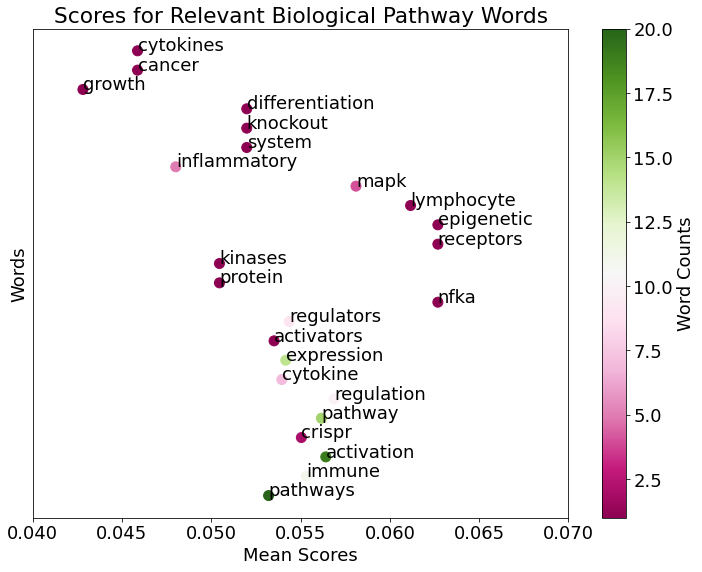

In [213]:
import matplotlib.pyplot as plt
import numpy as np


# Extract the relevant counts based on the relevant keys
relevant_counts = [keyword_counts[k] for k in relevant_keys]

# Extract the relevant scores based on the relevant keys (assuming you have already defined relevant_scores)
# relevant_scores = [keyword_scores[k] for k in relevant_keys]

plt.figure(figsize=[12, 9])

# Create the scatter plot and color it by the counts
plt.scatter(relevant_scores, np.arange(len(relevant_scores)), s=100,
            c=relevant_counts, cmap='PiYG')

# Add labels to each point
for i, word in enumerate(relevant_keys):
    plt.text(relevant_scores[i], i, word)

# Set plot labels and title
plt.xlabel('Mean Scores')
plt.ylabel('Words')
plt.title('Scores for Relevant Biological Pathway Words')

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Word Counts')

# Show the plot
plt.xlim(0.04, 0.07)
plt.yticks([])
plt.show()


### Discretized heatmap

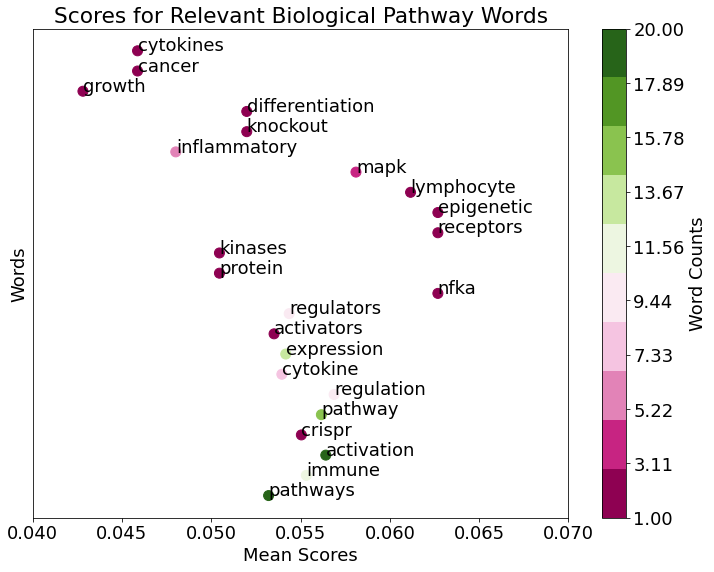

In [222]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Assuming you have already defined the following variables:
# relevant_keys, keyword_counts, relevant_scores

# Extract the relevant counts based on the relevant keys
relevant_counts = [keyword_counts[k] for k in relevant_keys]

# Extract the relevant scores based on the relevant keys (assuming you have already defined relevant_scores)
# relevant_scores = [keyword_scores[k] for k in relevant_keys]

plt.figure(figsize=[12, 9])

# Create a discrete colormap using 'PiYG' colormap and specifying the number of levels
num_levels = 10  # You can adjust this value to set the number of discrete levels in the colormap
cmap = ListedColormap(plt.cm.PiYG(np.linspace(0, 1, num_levels)))

# Create the scatter plot and color it by the counts using the discrete colormap
plt.scatter(relevant_scores, np.arange(len(relevant_scores)), s=100,
            c=relevant_counts, cmap=cmap)

# Add labels to each point
for i, word in enumerate(relevant_keys):
    plt.text(relevant_scores[i], i, word)

# Set plot labels and title
plt.xlabel('Mean Scores')
plt.ylabel('Words')
plt.title('Scores for Relevant Biological Pathway Words')

# Add a colorbar with discrete levels
cbar = plt.colorbar(ticks=np.linspace(min(relevant_counts), max(relevant_counts), num_levels))
cbar.set_label('Word Counts')

# Show the plot
plt.xlim(0.04, 0.07)
plt.yticks([])
plt.show()


### 15+ rounds

In [254]:
keyword_scores = {}
keyword_counts = {}
keyword_std = {}

for summary, score in zip(summaries_list, scores_list):
    keywords = extract_keywords(summary, num_keywords=50)
    for k in keywords:
        try:
            keyword_scores[k].append(score)
        except:
            keyword_scores[k] = [score]
            
# Take averages
for k in keyword_scores.keys():
    keyword_std[k] = np.std(keyword_scores[k])
    keyword_counts[k] = len(keyword_scores[k])
    keyword_scores[k] = np.mean(keyword_scores[k])

In [255]:
list(keyword_scores.keys())

['genes',
 'observation',
 'hits',
 'scores',
 'action',
 'expression',
 'signaling',
 'reasoning',
 'involved',
 'cell',
 'based',
 'list',
 'perturbation',
 'indicating',
 'identified',
 'positive',
 'protein',
 'kinases',
 'activation',
 'production',
 'upon',
 'summary',
 'identify',
 'development',
 'related',
 'score',
 'contains',
 'experimental',
 'pathways',
 'include',
 'function',
 'treg',
 'differential',
 'gene',
 'absolute',
 'highly',
 'negative',
 'provide',
 'greater',
 'significant',
 'level',
 'changes',
 'across',
 'cycles',
 'kinase',
 'regulators',
 'mediating',
 'regulatory',
 'perform',
 'analysis',
 'selected',
 'log',
 'fold',
 'change',
 'regulation',
 'results',
 'significantly',
 'experimentally',
 'measure',
 'additional',
 'perturb',
 'candidate',
 'experiment',
 'new',
 'perturbing',
 'hit',
 'continue',
 'maximizing',
 'identification',
 'next',
 'previous',
 'pathway',
 'immune',
 'also',
 'signal',
 'tranduction',
 'purpose',
 'reported',
 'goal',
 'm

In [257]:
relevant_keys =  [
     'protein', 'kinases', 'development',
     'regulation', 'pathway',
     'immune',  'mapk', 'regulate',
    'transcription', 'cytokine', 'factors','gpcrs', 'cycle', 'apoptosis',
    'inflammatory',  'inflammation', 'cancer', 'cytokines', 'diet', 
    'sirna']
#relevant_keys = ['signaling', 'cycles', 'immune', 'regulation', 'cytokine', 'regulators', 'proliferation', 'apoptosis', 'nfka', 'transcription', 'kinases', 'epigenetic', 'lymphocyte', 'mapk', 'inflammatory']
relevant_scores = [keyword_scores[k] for k in relevant_keys]

KeyError: 'gpcrs'

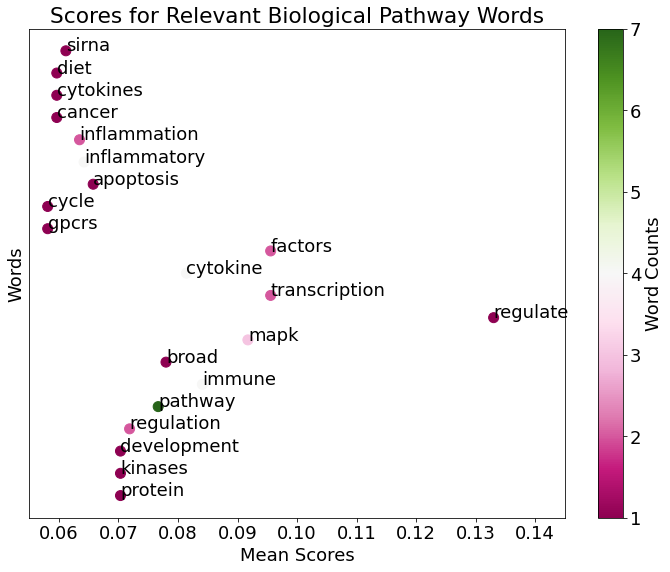

In [240]:
import matplotlib.pyplot as plt
import numpy as np


# Extract the relevant counts based on the relevant keys
relevant_counts = [keyword_counts[k] for k in relevant_keys]

# Extract the relevant scores based on the relevant keys (assuming you have already defined relevant_scores)
# relevant_scores = [keyword_scores[k] for k in relevant_keys]

plt.figure(figsize=[12, 9])

# Create the scatter plot and color it by the counts
plt.scatter(relevant_scores, np.arange(len(relevant_scores)), s=100,
            c=relevant_counts, cmap='PiYG')

# Add labels to each point
for i, word in enumerate(relevant_keys):
    plt.text(relevant_scores[i], i, word)

# Set plot labels and title
plt.xlabel('Mean Scores')
plt.ylabel('Words')
plt.title('Scores for Relevant Biological Pathway Words')

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Word Counts')

# Show the plot
plt.yticks([])
plt.xlim([0.055, 0.145])
plt.show()


### Just looking at no failure filter results

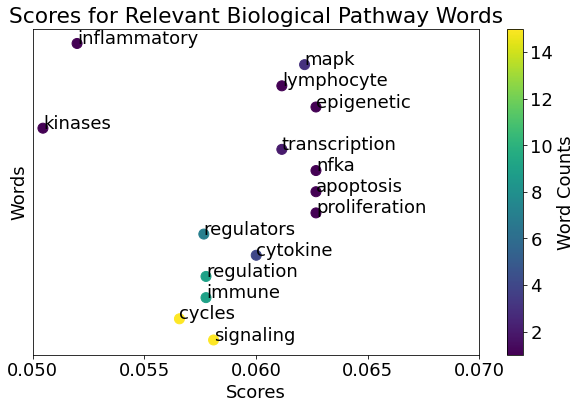

In [177]:
import matplotlib.pyplot as plt
import numpy as np

relevant_keys = ['signaling', 'cycles', 'immune', 'regulation', 'cytokine', 'regulators',
                 'proliferation', 'apoptosis', 'nfka', 'transcription', 'kinases', 'epigenetic',
                 'lymphocyte', 'mapk', 'inflammatory']

# Extract the relevant counts based on the relevant keys
relevant_counts = [keyword_counts[k] for k in relevant_keys]

# Extract the relevant scores based on the relevant keys (assuming you have already defined relevant_scores)
# relevant_scores = [keyword_scores[k] for k in relevant_keys]

plt.figure(figsize=[10, 6])

# Create the scatter plot and color it by the counts
plt.scatter(relevant_scores, np.arange(len(relevant_scores)), s=100,
            c=relevant_counts, cmap='viridis')

# Add labels to each point
for i, word in enumerate(relevant_keys):
    plt.text(relevant_scores[i], i, word)

# Set plot labels and title
plt.xlabel('Scores')
plt.ylabel('Words')
plt.title('Scores for Relevant Biological Pathway Words')

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Word Counts')

# Show the plot
plt.xlim(0.05, 0.07)
plt.yticks([])
plt.show()


In [246]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np


# Labels for each passage (1 for positive, 0 for negative)
labels = binarize

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the passages into TF-IDF features
tfidf_matrix = vectorizer.fit_transform(summaries_list)

# Compute chi-square statistic between each feature (word) and the labels
chi2_stat, p_values = chi2(tfidf_matrix, labels)

# Get the indices of the top distinguishing features (words)
num_keywords = 100  # Number of keywords to select
top_keywords_indices = np.argsort(chi2_stat)[-num_keywords:]

# Get the actual keywords from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names()
distinguishing_keywords = [feature_names[idx] for idx in top_keywords_indices]

print("Distinguishing Keywords:", distinguishing_keywords)

Distinguishing Keywords: ['signaling', 'experiment', 'roles', 'immune', 'jak', 'perturbing', 'cytokine', 'data', 'factors', 'also', 'involved', 'genetic', 'pathways', 'round', 'akt', 'cd', 'as', 'across', 'negatively', 'these', 'up', 'their', 'regulated', 'into', 'regulating', 'system', 'identifiers', 'may', 'processes', 'have', 'including', 'perturbation', 'suggest', 'transcription', 'candidates', 'role', 'information', 'human', 'received', 'regulate', 'its', 'generated', 'yield', 'likelihood', 'tcr', 'positively', 'tool', 'analyzing', 'downregulation', 'tgfb', 'use', 'appear', 'regulates', 'decrease', 'factor', 'seem', 'exceeded', 'upregulate', 'both', 'can', 'most', 'mapk', 'increased', 'such', 'algorithm', 'strength', 'showing', 'actually', 'costim', 'ranged', 'real', 'rationale', 'strongly', 'prioritization', 'proposed', 'completed', 'cofactors', 'only', 'good', 'nfkb', 'hypothetical', 'cytotoxic', 'insights', 'signalling', 'myself', 'rheumatoid', 'arthritis', 'gain', 'apply', 'cr